# Training results

_Imports and configs_

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import medfilt, wiener
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [65]:
sns.set()

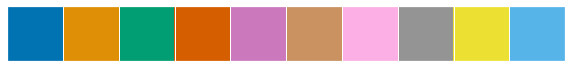

In [66]:
colors = sns.color_palette("colorblind")
# sns.palplot(sns.color_palette("Paired"))
sns.palplot(colors)
sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-'})

_Functions_

In [67]:
def get_metrics(fn):
    """ Get metrics from training log file.
        The metrics are:
            - training loss
            - validation loss
            - balanced accuracy (validation subset)
    """
    ensemble = []
    with open(fn) as f_pos:
        lines = f_pos.readlines()
        for l in lines:
            if l[0:5] == 'Model':
                ensemble.append({"training_losses":[],
                 "validation_losses":[],
                #  "accuracy":[],
                 "balanced_accuracy":[]})
            if l[0] == 'T':
                c = l.split()
                ensemble[-1]["training_losses"].append(float(c[4].strip(',')))
            elif l[0] == 'V':
                c = l.split()
                ensemble[-1]["validation_losses"].append(float(c[4].strip(',')))
                # ensemble[-1]["accuracy"].append(float(c[6].strip(',')))
                ensemble[-1]["balanced_accuracy"].append(float(c[8].strip(',')))
    return ensemble

In [85]:
def stats(ensemble):
    """ Calculate mean, min5 and max95 for each ensemble metric. 
    """
    mean = {"training_losses":[],
                 "validation_losses":[],
                 "balanced_accuracy":[]}
    max95 = {"training_losses":[],
                 "validation_losses":[],
                 "balanced_accuracy":[]}
    min5 = {"training_losses":[],
                 "validation_losses":[],
                 "balanced_accuracy":[]}
    for i in range(len(ensemble[0]["training_losses"])):
        for k in ensemble[0].keys():
            mean[k].append(np.mean([e[k][i] for e in ensemble]))
            # is there a better way to use limit this 90% interval? 
            min5[k].append(np.percentile([e[k][i] for e in ensemble],5))
            max95[k].append(np.percentile([e[k][i] for e in ensemble],95))
    for k in mean.keys():
        mean[k] = np.array(mean[k])
        min5[k] = np.array(min5[k])
        max95[k] = np.array(max95[k])
        
    return mean, min5, max95
    

In [84]:
def create_loss_plot(data, ax, color):
    """ Create loss plot for training and validation subsets
    """
    y_t, y_tmin, y_tmax = data[0]["training_losses"], data[1]["training_losses"], data[2]["training_losses"]
    y_v, y_vmin, y_vmax = data[0]["validation_losses"], data[1]["validation_losses"],data[2]["validation_losses"]
    ax = plt.plot(y_t, color=color, ls=':', label="train")
    ax = plt.plot(y_v, color=color, label="validation")
    ax = plt.fill_between(x, y_tmin, y_tmax, alpha=0.2, linewidth=0, facecolor=color)
    ax = plt.fill_between(x, y_vmin, y_vmax, alpha=0.2, linewidth=0, facecolor=color)
    ax = plt.ylabel("loss", fontsize=9)
    ax = plt.yticks(np.arange(0.4,1.05,0.2), fontsize=9)
    ax = plt.xticks(fontsize=9)
    ax = plt.xlim(-3,303)
    ax = plt.tick_params(length=1)
    

In [83]:
def create_balanced_accuracy_plot(datas, ax, c):
    """ Balanced accuracy plot
    """
    for i in range(len(datas)):
        y, y_min, y_max = datas[i][0]["balanced_accuracy"], datas[i][1]["balanced_accuracy"], datas[i][2]["balanced_accuracy"]
        ax = plt.plot(y, color=c[i])
        ax = plt.fill_between(x, y_min, y_max, alpha=0.2, linewidth=0, facecolor=c[i])
    ax = plt.xlabel("epoch", fontsize=9)
    ax = plt.ylabel("balanced accuracy", fontsize=9)
    ax = plt.ylim(0.40,1.0)
    ax = plt.xlim(-3,303)
    ax = plt.yticks(fontsize=9)
    ax = plt.xticks(fontsize=9)
        

_read training log files_

In [86]:
positives = stats(get_metrics("../data/logs/model-positive-13-adamw-lc5-2021-03-03"))

In [87]:
negatives = stats(get_metrics("../data/logs/model-negative-13-adamw-lc5-2021-03-03"))

In [88]:
random  = stats(get_metrics("../data/logs/model-random-13-adamw-lc5-2021-03-03"))

In [89]:
shuffled_snps = stats(get_metrics("../data/logs/model-shuffled-snps-13-adamw-lc5-2021-03-03"))

In [90]:
shuffled_ages = stats(get_metrics("../data/logs/model-shuffled-ages-13-adamw-lc5-2021-03-03"))

In [91]:
shuffled_parents = stats(get_metrics("../data/logs/model-shuffled-parents-13-adamw-lc5-2021-03-03"))

In [92]:
shuffled_labels = stats(get_metrics("../data/logs/model-shuffled-labels-13-adamw-lc5-2021-03-03"))

## Training results for different SNP datasets

Three sets with 1000 SNPs each one where defined:

- associated SNPs
- not associated SNPs
- random SNPs or randomly choosen SNPs  

Besides these sets, we made another four derived from the associated SNPs set.
- shuffled labels
- shuffled ages
- shuffled parent diagnosis
- shuffled SNPs or shuffled associated SNPs

These "shuffled" sets were used to observe the importance of some features. The great capacity of neural networks to fit data during training are well known. Therefore, we should look for the impact of this artificial noise at the validation subset inference.

The `shuffled associated SNPs` set was created to preserve the observed frequency for each SNP. With that, we reduce a possible bias present in regularization parameters that could affect the training using both of `not associated SNPs` and `random SNPs` sets.  

#### Comparação do treinamento com o conjunto aleatorizado de SNPs associados

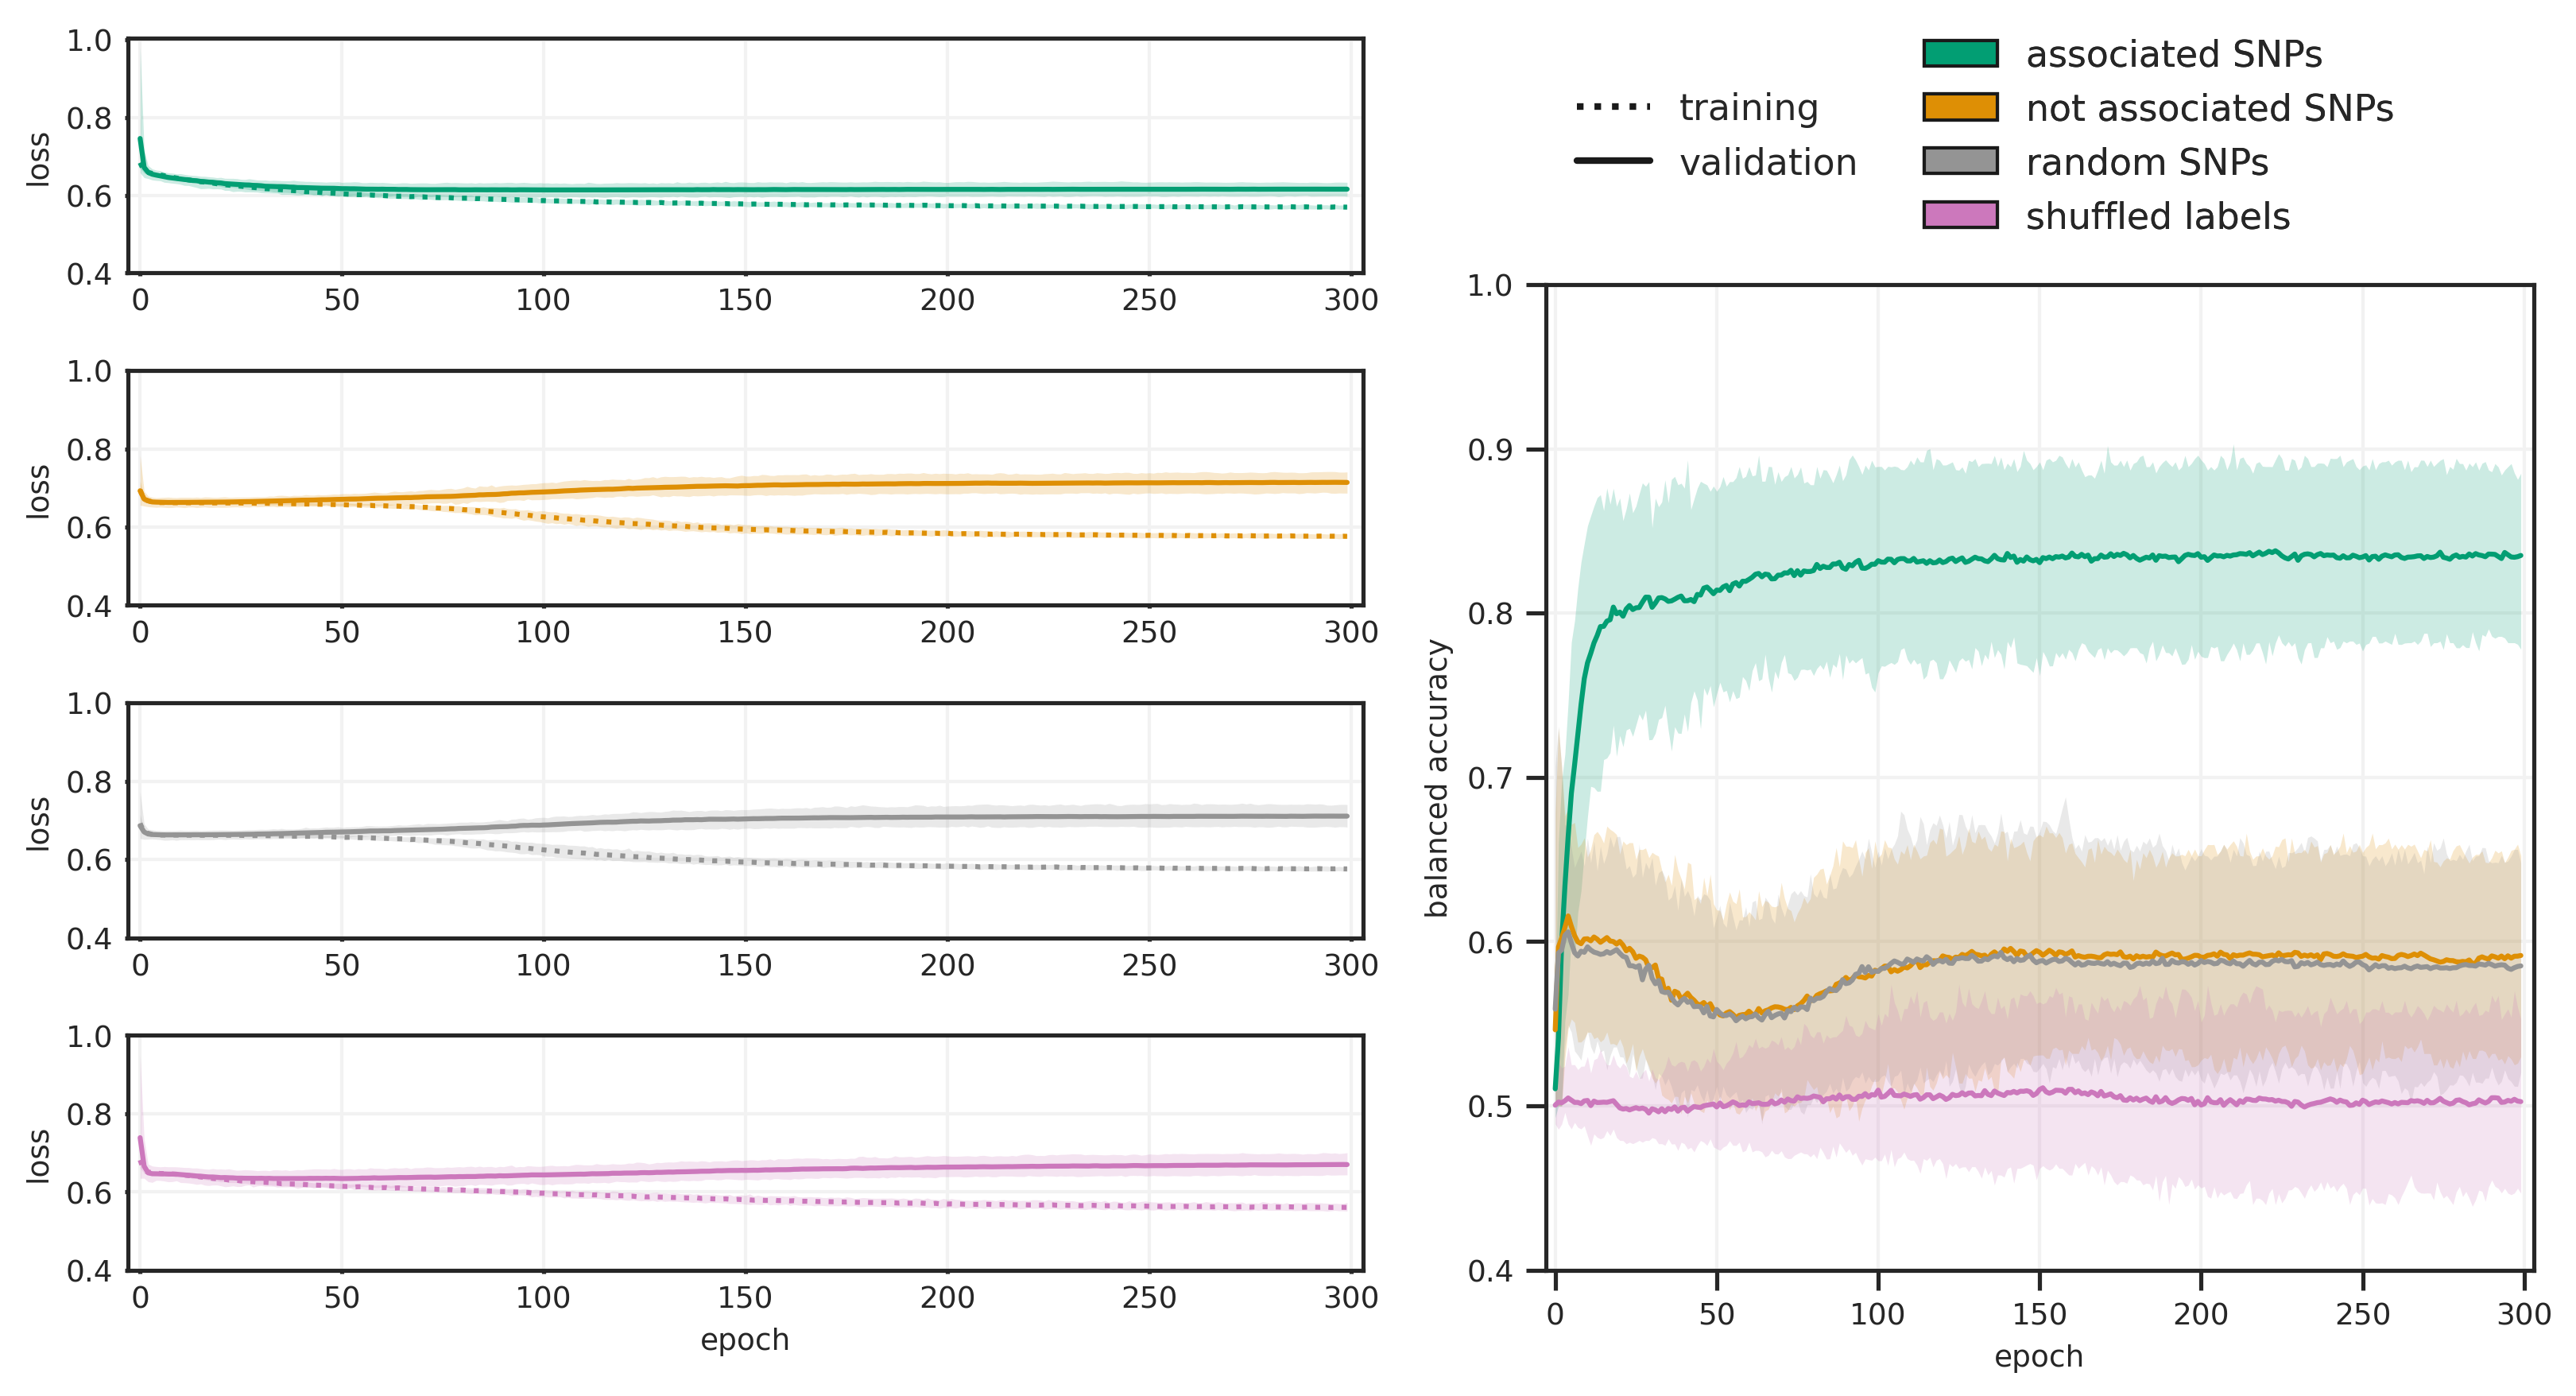

In [94]:
""" Training
"""
x = range(len(positives[0]["training_losses"]))
fig = plt.figure(figsize=(12,6), dpi=300)
ax_l1 = plt.subplot(421)
create_loss_plot(positives, ax_l1, colors[2])
ax_l2 = plt.subplot(423)
create_loss_plot(negatives, ax_l2, colors[1])
ax_l3 = plt.subplot(425)
create_loss_plot(random, ax_l3, colors[7])
ax_l4 = plt.subplot(427)
create_loss_plot(shuffled_labels, ax_l4, colors[4])
ax_l4 = plt.xlabel("epoch", fontsize=9)
ax_r = plt.subplot(122)
create_metric_plot([positives, negatives, random, shuffled_labels], ax_r,[colors[2], colors[1], colors[7], colors[4]] )
fig = plt.tight_layout()



legend_lines = [Line2D([0], [0], color='k', lw=2, ls=':', label='training'),
                   Line2D([0], [0], color='k', lw=2, label='validation')]
legend_colors = [Patch(facecolor=colors[2], edgecolor='k',label='associated SNPs'),
                 Patch(facecolor=colors[1], edgecolor='k',label='not associated SNPs'),
                 Patch(facecolor=colors[7], edgecolor='k',label='random SNPs'),
                 Patch(facecolor=colors[4], edgecolor='k',label='shuffled labels')]

box = ax_r.get_position()
ax_r.set_position([box.x0, box.y0,
                 box.width * 0.8, box.height * 0.8])
ax_r.add_artist(plt.legend(handles=legend_lines, loc='center right', frameon=False, bbox_to_anchor=(0.35, 1.15)))
ax_r.add_artist(plt.legend(handles=legend_colors, loc='center left', frameon=False, bbox_to_anchor=(0.35, 1.15)))
## to put legend below bacc plot
# ax_r.set_position([box.x0, box.y0 + box.height * 0.25,
#                  box.width * 0.75, box.height * 0.75])
# ax_r.add_artist(plt.legend(handles=legend_lines, loc='center right', frameon=False, bbox_to_anchor=(0.35, -0.3)))
# ax_r.add_artist(plt.legend(handles=legend_colors, loc='center left', frameon=False, bbox_to_anchor=(0.35, -0.3)))

# plt.savefig("./images/training_plot_13_adamw_lc5_20210303_90ci.svg")

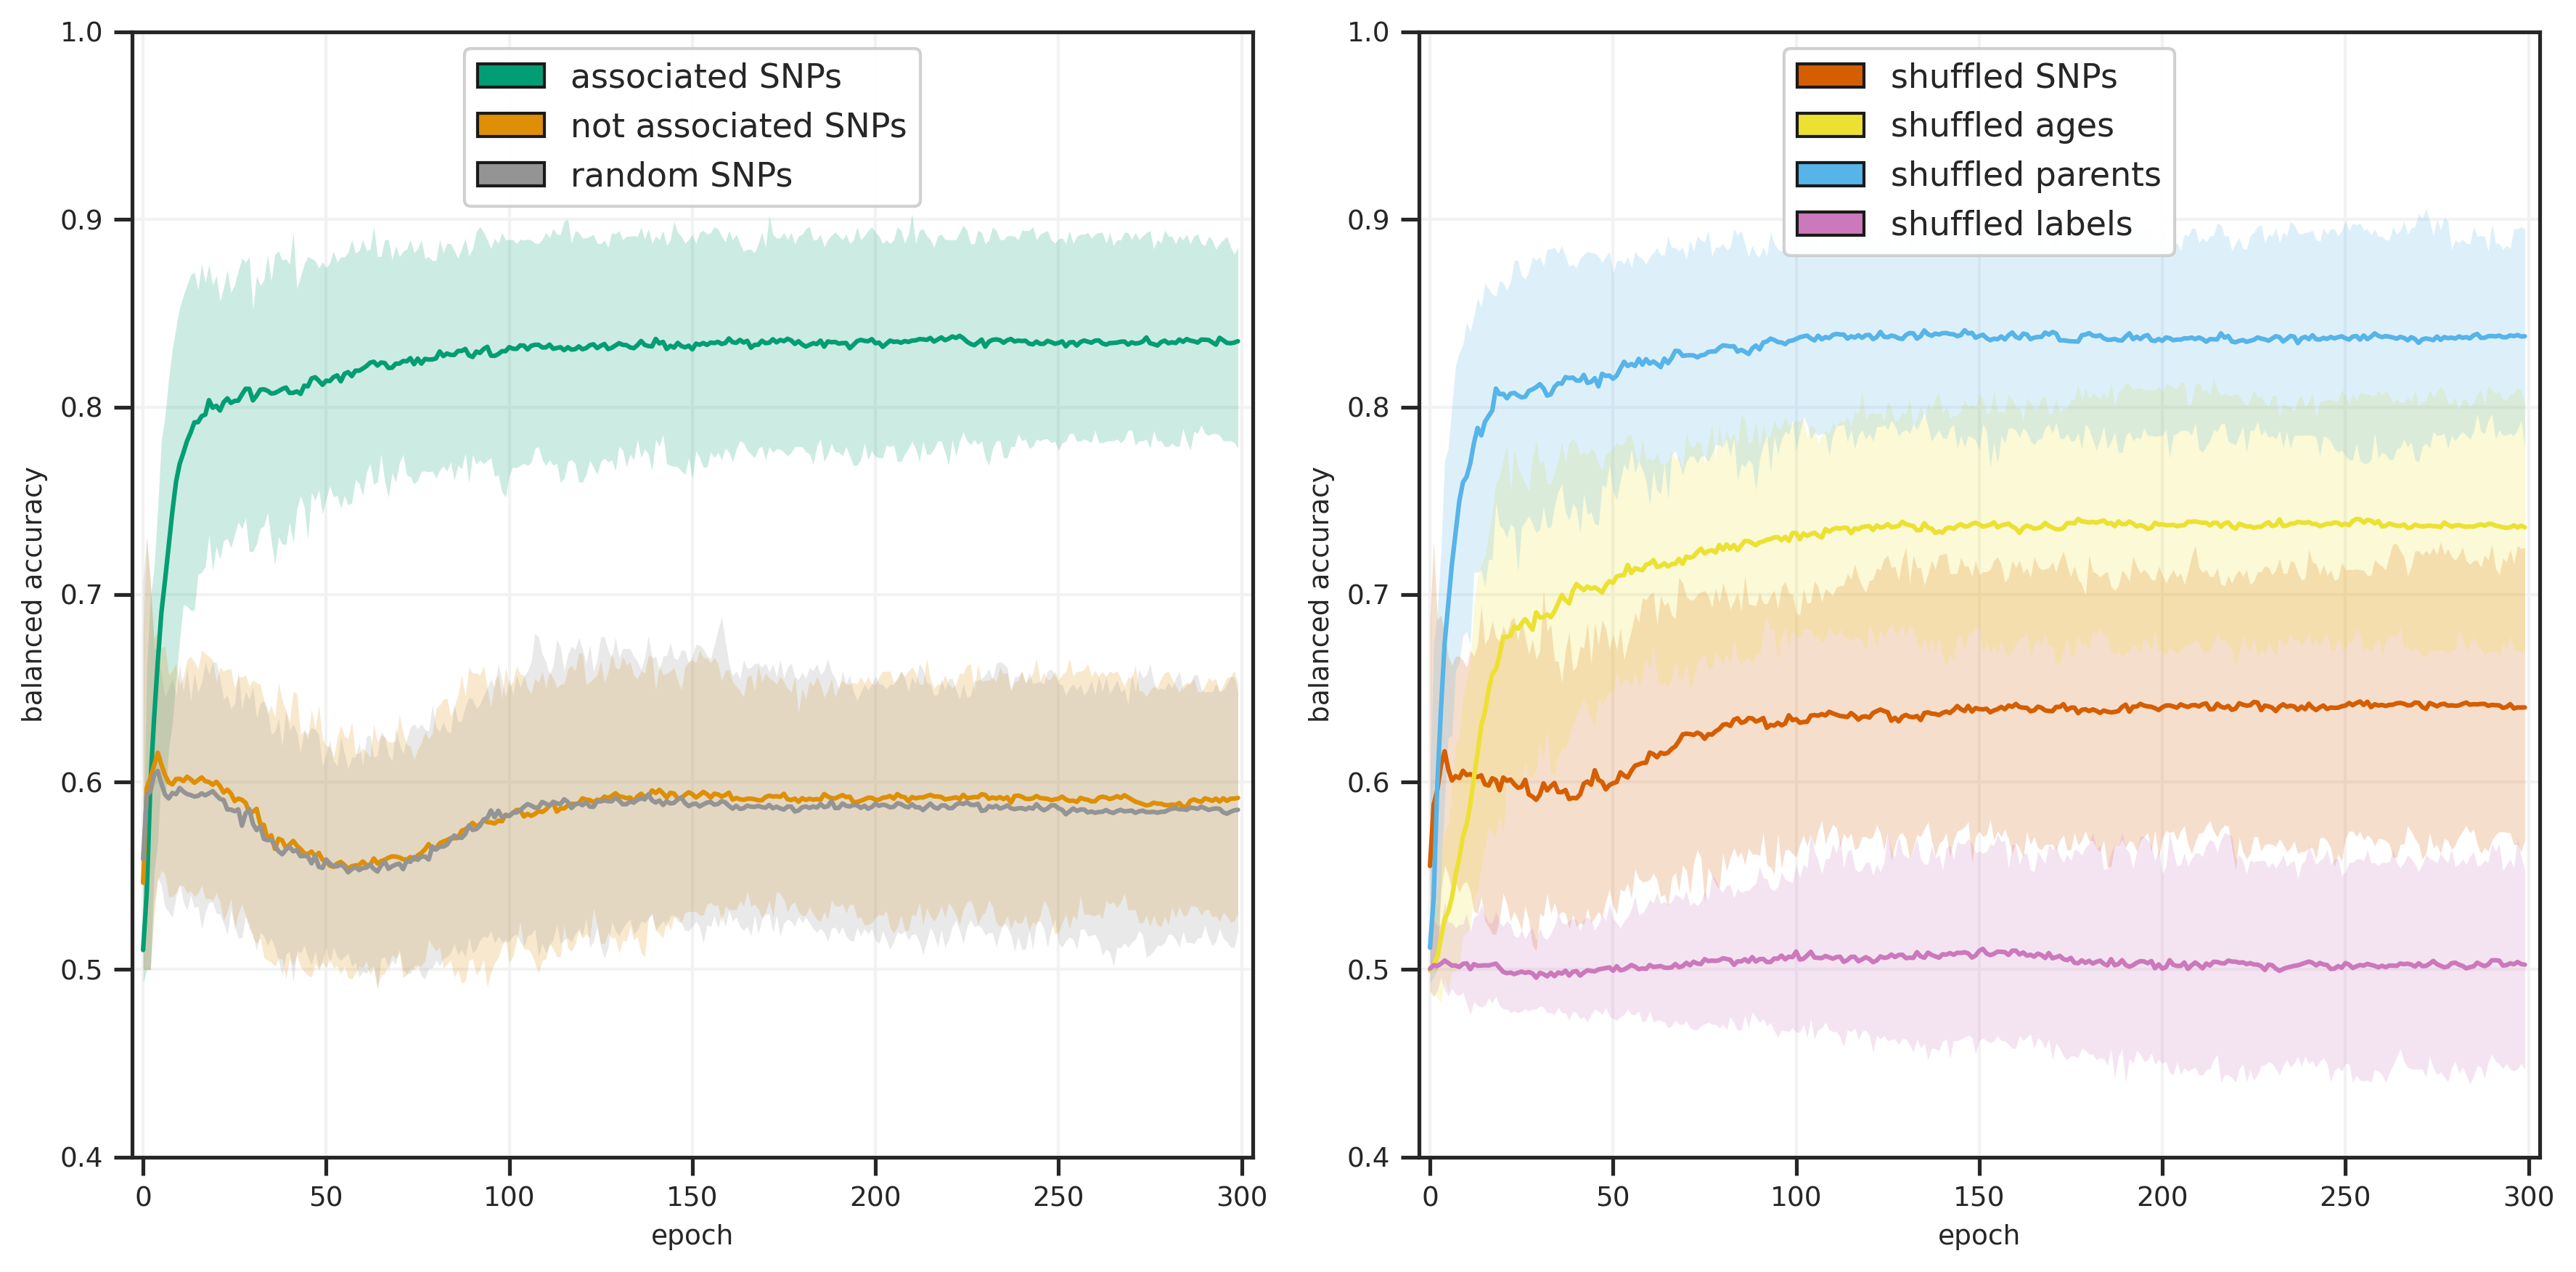

In [29]:
# create figure
x = range(len(positives[0]["training_losses"]))
fig = plt.figure(figsize=(12,6), dpi=300)
# ax_l1 = plt.subplot(7,2,1)
# create_loss_plot(positives, ax_l1, colors[2])
# ax_l2 = plt.subplot(7,2,3)
# create_loss_plot(negatives, ax_l2, colors[3])
# ax_l3 = plt.subplot(7,2,5)
# create_loss_plot(random, ax_l3, colors[7])
# ax_l4 = plt.subplot(7,2,7)
# create_loss_plot(shuffled_snps, ax_l4, colors[4])
# ax_l5 = plt.subplot(7,2,9)
# create_loss_plot(shuffled_ages, ax_l5, colors[4])
# ax_l6 = plt.subplot(7,2,11)
# create_loss_plot(shuffled_parents, ax_l6, colors[4])
# ax_l7 = plt.subplot(7,2,13)
# create_loss_plot(shuffled_labels, ax_l7, colors[4])
# ax_l7 = plt.xlabel("epoch", fontsize=9)
legend_1_colors = [Patch(facecolor=colors[2], edgecolor='k',label='associated SNPs'),
                 Patch(facecolor=colors[1], edgecolor='k',label='not associated SNPs'),
                 Patch(facecolor=colors[7], edgecolor='k',label='random SNPs')]

legend_2_colors = [Patch(facecolor=colors[3], edgecolor='k',label='shuffled SNPs'),
                 Patch(facecolor=colors[8], edgecolor='k',label='shuffled ages'),
                 Patch(facecolor=colors[9], edgecolor='k',label='shuffled parents'),
                 Patch(facecolor=colors[4], edgecolor='k',label='shuffled labels')]

ax_r1 = plt.subplot(121)
create_metric_plot([positives, negatives, random],
                   ax_r1,[colors[2], colors[1], colors[7]] )
ax_r1.add_artist(plt.legend(handles=legend_1_colors,loc='upper center'))
ax_r2 = plt.subplot(122)
create_metric_plot([shuffled_snps, shuffled_ages, shuffled_parents, shuffled_labels],
                   ax_r2,[colors[3], colors[8], colors[9], colors[4]] )
ax_r2.add_artist(plt.legend(handles=legend_2_colors,loc='upper center'))
fig = plt.tight_layout()



# legend_lines = [Line2D([0], [0], color='k', lw=2, ls=':', label='training'),
#                    Line2D([0], [0], color='k', lw=2, label='validation')]




# box = ax_r1.get_position()
# ax_r1.set_position([box.x0, box.y0,
#                  box.width * 0.8, box.height * 0.8])
# ax_r1.add_artist(plt.legend(handles=legend_lines, loc='center right', frameon=False, bbox_to_anchor=(0.35, 1.15)))
# ax_r1.add_artist(plt.legend(handles=legend_colors, loc='center left', frameon=False, bbox_to_anchor=(0.35, 1.15)))
## to put legend below bacc plot
# ax_r.set_position([box.x0, box.y0 + box.height * 0.25,
#                  box.width * 0.75, box.height * 0.75])
# ax_r.add_artist(plt.legend(handles=legend_lines, loc='center right', frameon=False, bbox_to_anchor=(0.35, -0.3)))
# ax_r.add_artist(plt.legend(handles=legend_colors, loc='center left', frameon=False, bbox_to_anchor=(0.35, -0.3)))

# plt.savefig("./images/training_plot_bacc_shuffled_13_adamw_lc5_20210303_90ci.svg")

(0.0, 1.0, 0.0, 1.0)

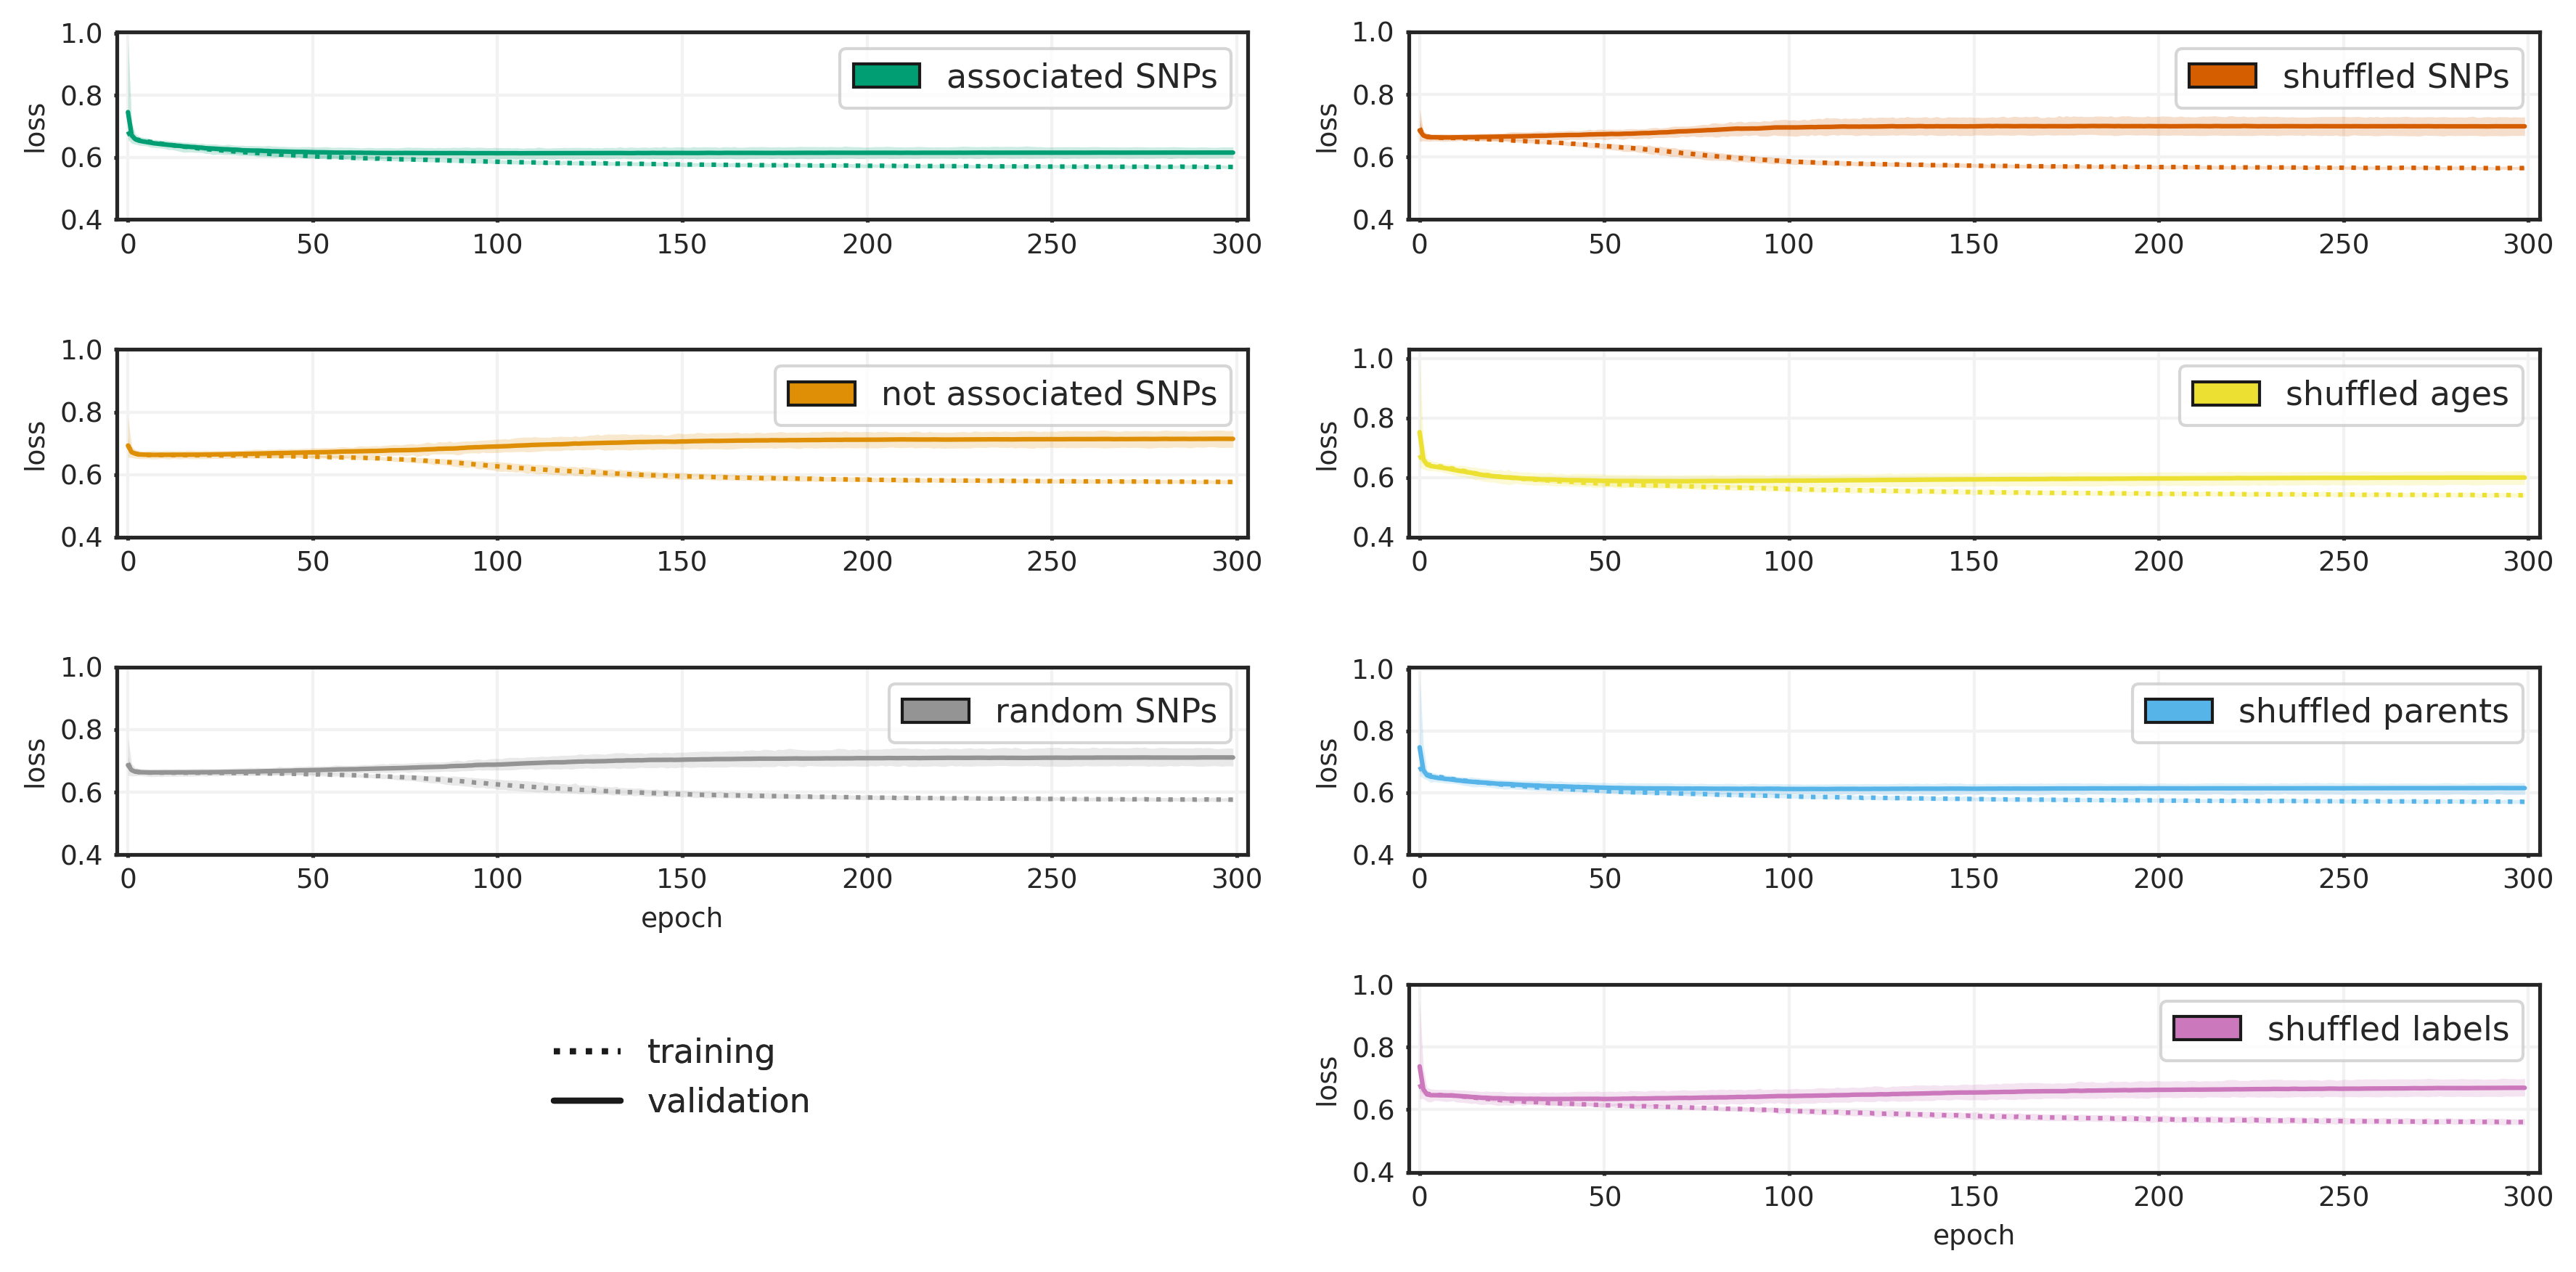

In [62]:
# create figure
x = range(len(positives[0]["training_losses"]))
fig = plt.figure(figsize=(12,6), dpi=300)
ax_l1 = plt.subplot(4,2,1)
create_loss_plot(positives, ax_l1, colors[2])
ax_l1.legend(handles=[Patch(facecolor=colors[2], edgecolor='k',label='associated SNPs')],loc='upper right')
ax_l2 = plt.subplot(4,2,3)
create_loss_plot(negatives, ax_l2, colors[1])
ax_l2.legend(handles=[Patch(facecolor=colors[1], edgecolor='k',label='not associated SNPs')],loc='upper right')
ax_l3 = plt.subplot(4,2,5)
create_loss_plot(random, ax_l3, colors[7])
ax_l3.legend(handles=[Patch(facecolor=colors[7], edgecolor='k',label='random SNPs')],loc='upper right')
ax_l3 = plt.xlabel("epoch", fontsize=9)
ax_l4 = plt.subplot(4,2,2)
create_loss_plot(shuffled_snps, ax_l4, colors[3])
ax_l4.legend(handles=[Patch(facecolor=colors[3], edgecolor='k',label='shuffled SNPs')],loc='upper right')
ax_l5 = plt.subplot(4,2,4)
create_loss_plot(shuffled_ages, ax_l5, colors[8])
ax_l5.legend(handles=[Patch(facecolor=colors[8], edgecolor='k',label='shuffled ages')],loc='upper right')
ax_l6 = plt.subplot(4,2,6)
create_loss_plot(shuffled_parents, ax_l6, colors[9])
ax_l6.legend(handles=[Patch(facecolor=colors[9], edgecolor='k',label='shuffled parents')],loc='upper right')
ax_l7 = plt.subplot(4,2,8)
create_loss_plot(shuffled_labels, ax_l7, colors[4])
ax_l7.legend(handles=[Patch(facecolor=colors[4], edgecolor='k',label='shuffled labels')],loc='upper right')
ax_l7 = plt.xlabel("epoch", fontsize=9)

ax_l8 = plt.subplot(4,2,7)
# ax_r = plt.subplot(122)
# create_metric_plot([positives, negatives, random, shuffled_snps, shuffled_ages, shuffled_parents, shuffled_labels],
#                    ax_r,[colors[2], colors[3], colors[7], colors[4], colors[4], colors[4], colors[4]] )
fig = plt.tight_layout()



legend_lines = [Line2D([0], [0], color='k', lw=2, ls=':', label='training'),
                   Line2D([0], [0], color='k', lw=2, label='validation')]
# legend_colors = [Patch(facecolor=colors[2], edgecolor='k',label='associated SNPs'),
#                  Patch(facecolor=colors[3], edgecolor='k',label='not associated SNPs'),
#                  Patch(facecolor=colors[7], edgecolor='k',label='random SNPs'),
#                  Patch(facecolor=colors[4], edgecolor='k',label='shuffled')]

ax_l8.add_artist(plt.legend(handles=legend_lines, loc='center', frameon=False))
ax_l8.axis('off')
# print(box)
# ax_l1.set_position([box.x0, box.y0,
#                  box.width * 0.8, box.height * 0.8])
# ax_l8.add_artist(plt.legend(handles=legend_lines, loc='center r', frameon=False, bbox_to_anchor=(0.35, 1.15)))
# ax_r.add_artist(plt.legend(handles=legend_colors, loc='center left', frameon=False, bbox_to_anchor=(0.35, 1.15)))

## to put legend below bacc plot
# ax_r.set_position([box.x0, box.y0 + box.height * 0.25,
#                  box.width * 0.75, box.height * 0.75])
# ax_r.add_artist(plt.legend(handles=legend_lines, loc='center right', frameon=False, bbox_to_anchor=(0.35, -0.3)))
# ax_r.add_artist(plt.legend(handles=legend_colors, loc='center left', frameon=False, bbox_to_anchor=(0.35, -0.3)))

# plt.savefig("./images/training_plot_adamw_lc2_20210116.svg")

## End

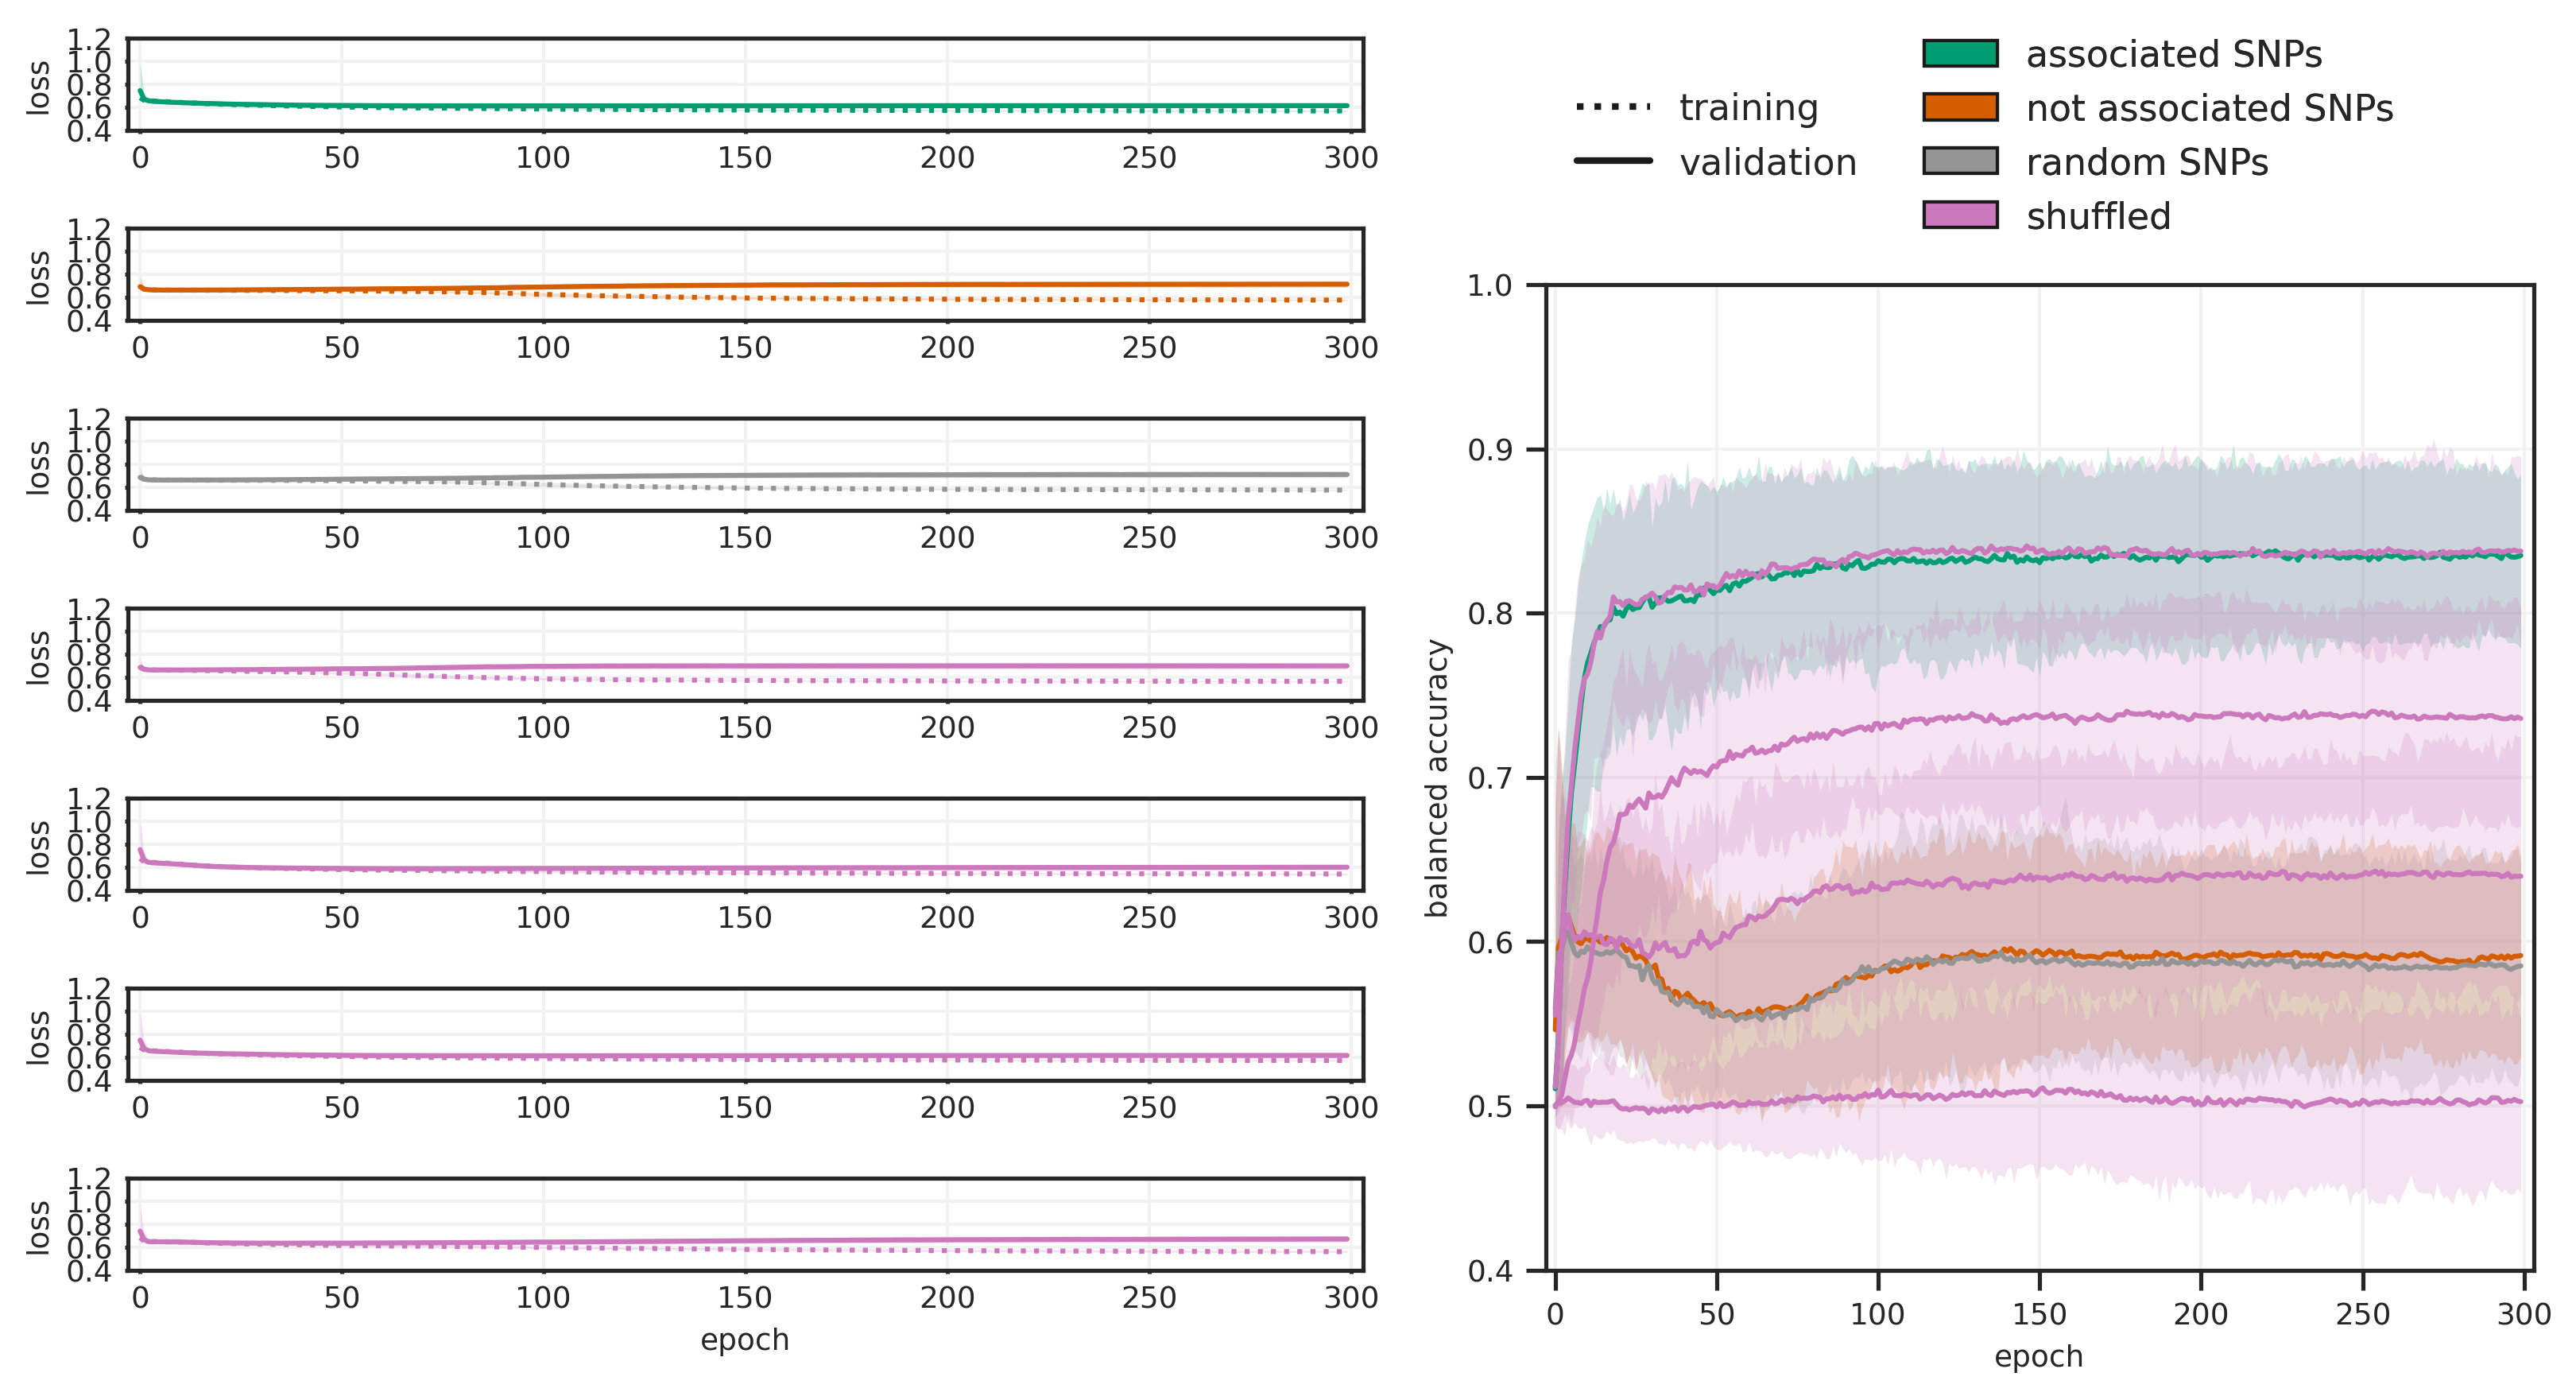

In [16]:
# create figure
x = range(len(positives[0]["training_losses"]))
fig = plt.figure(figsize=(12,6), dpi=300)
ax_l1 = plt.subplot(7,2,1)
create_loss_plot(positives, ax_l1, colors[2])
ax_l2 = plt.subplot(7,2,3)
create_loss_plot(negatives, ax_l2, colors[3])
ax_l3 = plt.subplot(7,2,5)
create_loss_plot(random, ax_l3, colors[7])
ax_l4 = plt.subplot(7,2,7)
create_loss_plot(shuffled_snps, ax_l4, colors[4])
ax_l5 = plt.subplot(7,2,9)
create_loss_plot(shuffled_ages, ax_l5, colors[4])
ax_l6 = plt.subplot(7,2,11)
create_loss_plot(shuffled_parents, ax_l6, colors[4])
ax_l7 = plt.subplot(7,2,13)
create_loss_plot(shuffled_labels, ax_l7, colors[4])
ax_l7 = plt.xlabel("epoch", fontsize=9)
ax_r = plt.subplot(122)
create_metric_plot([positives, negatives, random, shuffled_snps, shuffled_ages, shuffled_parents, shuffled_labels],
                   ax_r,[colors[2], colors[3], colors[7], colors[4], colors[4], colors[4], colors[4]] )
fig = plt.tight_layout()



legend_lines = [Line2D([0], [0], color='k', lw=2, ls=':', label='training'),
                   Line2D([0], [0], color='k', lw=2, label='validation')]
legend_colors = [Patch(facecolor=colors[2], edgecolor='k',label='associated SNPs'),
                 Patch(facecolor=colors[3], edgecolor='k',label='not associated SNPs'),
                 Patch(facecolor=colors[7], edgecolor='k',label='random SNPs'),
                 Patch(facecolor=colors[4], edgecolor='k',label='shuffled')]

box = ax_r.get_position()
ax_r.set_position([box.x0, box.y0,
                 box.width * 0.8, box.height * 0.8])
ax_r.add_artist(plt.legend(handles=legend_lines, loc='center right', frameon=False, bbox_to_anchor=(0.35, 1.15)))
ax_r.add_artist(plt.legend(handles=legend_colors, loc='center left', frameon=False, bbox_to_anchor=(0.35, 1.15)))
## to put legend below bacc plot
# ax_r.set_position([box.x0, box.y0 + box.height * 0.25,
#                  box.width * 0.75, box.height * 0.75])
# ax_r.add_artist(plt.legend(handles=legend_lines, loc='center right', frameon=False, bbox_to_anchor=(0.35, -0.3)))
# ax_r.add_artist(plt.legend(handles=legend_colors, loc='center left', frameon=False, bbox_to_anchor=(0.35, -0.3)))

# plt.savefig("./images/training_plot_adamw_lc2_20210116.svg")